## AMP with SE 

--- δ:  0.5  ---


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

--- δ:  1.0  ---


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

--- δ:  1.5  ---


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

--- δ:  2.0  ---


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

--- δ:  2.5  ---


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

--- δ:  3.0  ---


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

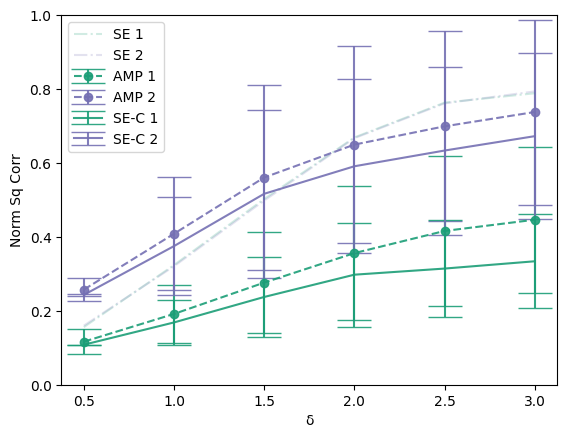

In [1]:
import numpy as np
import jax.numpy as jnp
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal

p = 500
σ = 0.01 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 3
δ_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# seed = 29
# nprandom.seed(2*seed)

norm_sq_corr_1_lists = [[] for i in range(len(δ_list))]
norm_sq_corr_2_lists = [[] for i in range(len(δ_list))]

norm_sq_corr_1_avg_list = []
norm_sq_corr_2_avg_list = []
norm_sq_corr_1_std_list = []
norm_sq_corr_2_std_list = []

norm_sq_corr_1_SE_list = []
norm_sq_corr_2_SE_list = []

norm_sq_corr_1_SE_fixed_lists = [[] for i in range(len(δ_list))]
norm_sq_corr_2_SE_fixed_lists = [[] for i in range(len(δ_list))]

norm_sq_corr_1_SE_fixed_avg_list = []
norm_sq_corr_2_SE_fixed_avg_list = []
norm_sq_corr_1_SE_fixed_std_list = []
norm_sq_corr_2_SE_fixed_std_list = []

mse_1_list = []
mse_2_list = []
mse_1_SE_list = []
mse_2_SE_list = []
post_list = []
true_post_list = []

for i in range(len(δ_list)):
    δ = δ_list[i]
    print("--- δ: ", δ, " ---")

    n = int(δ * p)
    B̃_cov = np.eye(L)

    # Gaussian Prior
    # signal_prior = GaussianSignal(B̃_cov)

    # Sparse Prior
    α = 0.8 # sparsity parameter
    σ_l_arr = np.array([1, 1]) # signal standard deviation
    signal_prior = SparseGaussianSignal(α, δ, σ_l_arr)
    B̃ = signal_prior.sample(p)

    # Sparse Diff Prior
    # ρ_1 = 1
    # σ_w = 1.0 # The larger the σ_w, the more different the entries of the signal will be
    # α = 1.0 # α = 1 means all signal entries are different
    # B̃ = SparseDiffSignal(δ, ρ_1, σ_w, α).sample(p)

    # Changepoint locations
    Δ = lambda n: int(n/5)
    C_s = amp.signal_configuration.generate_C_distanced(n, L, Δ = Δ(n))

    true_chgpt_locations = lambda n: [int(n/3)]
    ϕ = amp.signal_configuration.C_to_marginal(C_s) 

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later
    # η = nprandom.normal(0.0, σ, (n, 1)) # noise

    # Select where the true changepoint will be, as that will highly affect the result. 
    # C_full = np.triu(np.ones((n, n)), k=0).astype(int) # Here we are creating the matrix of all possible C's. This assumes that one changepoint happens forsure between 0≤t≤n-1. 
    # C_s = C_full[int(3*n/8):int(5*n/8)] # Ask the AMP to search over a continuum of possible changepoint locations 
    # C_s = C_full[np.array([int(n/2)])] # Ask the AMP to search over 3 possible changepoint locations
    # C_true = C_s[1] # Select the true change point to lie in the middle
    # C_true = C_full[np.array([int(n/2)])][0]

    for trial_num in range(num_trials):

        C_true = np.zeros((n, )).astype(int)
        loc = 0
        for i in range(len(true_chgpt_locations(n)) + 1):
            if len(true_chgpt_locations(n)) == 0:
                break
            if i >= len(true_chgpt_locations(n)):
                C_true[loc:] = i
                break
            C_true[loc:true_chgpt_locations(n)[i]] = i
            loc = true_chgpt_locations(n)[i]

        # Generate the observation vector Y
        X = nprandom.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        assert Θ.shape == (n, L)
        Y = changepoint_jax.q(Θ, C_true, σ).sample()
        assert Y.shape == (n, 1)

        B̂, Θ_t, ν, ν̂ = GAMP(T, ϕ, σ, X, Y, signal_prior = signal_prior, verbose=False, seed=None)
        κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
        ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, δ, p, ϕ, L, σ, 2 * T, tqdm_disable = True)

        # print("Calculating posterior...")
        # post = amp.posterior.compute_posterior(C_s, Θ_t, Y, n, jnp.array(ρ), σ, ν, κ_T)
        # MAP_C = amp.posterior.MAP(C_s, post)
        # MAP_chgpt_vec = amp.signal_configuration.C_to_chgpt(MAP_C)
        # AMP_K̂ = MAP_chgpt_vec.shape[0]
        # post_list.append(post)

        norm_sq_corr_1_lists[i].append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        norm_sq_corr_2_lists[i].append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        norm_sq_corr_1_SE_fixed_lists[i].append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0])) # Technically shouldn't need to do this since f is always optimal in our case right? 
        norm_sq_corr_2_SE_fixed_lists[i].append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))

    norm_sq_corr_1_SE_list.append(ν[0, 0] / ρ[0, 0])
    norm_sq_corr_2_SE_list.append(ν[1, 1] / ρ[1, 1])
    # mse_1_list.append(MSE(B̂[:, 0], B̃[:, 0]))
    # mse_2_list.append(MSE(B̂[:, 1], B̃[:, 1]))
    # mse_1_SE_list.append(δ * (ρ[0, 0] - ν[0, 0]))
    # mse_2_SE_list.append(δ * (ρ[1, 1] - ν[1, 1]))

    norm_sq_corr_1_avg_list.append(np.mean(norm_sq_corr_1_lists[i]))
    norm_sq_corr_2_avg_list.append(np.mean(norm_sq_corr_2_lists[i]))
    norm_sq_corr_1_std_list.append(np.std(norm_sq_corr_1_lists[i]))
    norm_sq_corr_2_std_list.append(np.std(norm_sq_corr_2_lists[i]))

    norm_sq_corr_1_SE_fixed_avg_list.append(np.mean(norm_sq_corr_1_SE_fixed_lists[i]))
    norm_sq_corr_2_SE_fixed_avg_list.append(np.mean(norm_sq_corr_2_SE_fixed_lists[i]))
    norm_sq_corr_1_SE_fixed_std_list.append(np.std(norm_sq_corr_1_SE_fixed_lists[i]))
    norm_sq_corr_2_SE_fixed_std_list.append(np.std(norm_sq_corr_2_SE_fixed_lists[i]))


# Sqcorr plots with error bars
plt.errorbar(δ_list, norm_sq_corr_1_avg_list, yerr=norm_sq_corr_1_std_list, label="AMP 1", marker="o", ls="--", c=PAL[0], alpha = 0.9)
plt.errorbar(δ_list, norm_sq_corr_2_avg_list, yerr=norm_sq_corr_2_std_list, label="AMP 2", marker="o", ls="--", c=PAL[2], alpha = 0.9)
plt.errorbar(δ_list, norm_sq_corr_1_SE_fixed_avg_list, yerr=norm_sq_corr_1_SE_fixed_std_list, label="SE-C 1", ls="-", c=PAL[0], alpha = 0.9)
plt.errorbar(δ_list, norm_sq_corr_2_SE_fixed_avg_list, yerr=norm_sq_corr_2_SE_fixed_std_list, label="SE-C 2", ls="-", c=PAL[2], alpha = 0.9)
plt.plot(δ_list, norm_sq_corr_1_SE_list, label="SE 1", ls="-.", c=PAL[0], alpha = 0.2)
plt.plot(δ_list, norm_sq_corr_2_SE_list, label="SE 2", ls="-.", c=PAL[2], alpha = 0.2)
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.ylim(0, 1)
plt.legend()
plt.show()



# # Sqcorr plots
# plt.plot(δ_list, norm_sq_corr_1_list, label="AMP 1", marker="o", ls="--", c=PAL[0])
# plt.plot(δ_list, norm_sq_corr_2_list, label="AMP 2", marker="o", ls="--", c=PAL[2])
# plt.plot(δ_list, norm_sq_corr_1_SE_list, label="SE 1", ls="-.", c=PAL[0], alpha = 0.2)
# plt.plot(δ_list, norm_sq_corr_2_SE_list, label="SE 2", ls="-.", c=PAL[2], alpha = 0.2)
# plt.plot(δ_list, norm_sq_corr_1_SE_fixed_list, label="SE-C 1", ls="-", c=PAL[0])
# plt.plot(δ_list, norm_sq_corr_2_SE_fixed_list, label="SE-C 2", ls="-", c=PAL[2])
# plt.xlabel("δ")
# plt.ylabel("Norm Sq Corr")
# plt.ylim(0, 1)
# plt.legend()
# plt.show()

# # MSE plots
# plt.plot(δ_list, mse_1_list, label="MSE Signal 1", marker="o", ls="--", c=PAL[0])
# plt.plot(δ_list, mse_2_list, label="MSE Signal 2", marker="o", ls="--", c=PAL[2])
# plt.plot(δ_list, mse_1_SE_list, label="MSE SE Signal 1", ls="-", c=PAL[0])
# plt.plot(δ_list, mse_2_SE_list, label="MSE SE Signal 2", ls="-", c=PAL[2])
# plt.xlabel("δ")
# plt.ylabel("MSE")
# plt.ylim(0, 1)
# plt.legend()
# plt.show()


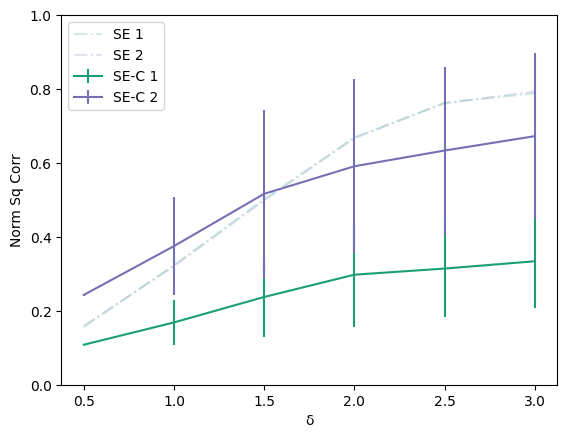

In [2]:
# Sqcorr plots with error bars
# plt.errorbar(δ_list, norm_sq_corr_1_avg_list, yerr=norm_sq_corr_1_std_list, label="AMP 1", marker="o", ls="--", c=PAL[0])
# plt.errorbar(δ_list, norm_sq_corr_2_avg_list, yerr=norm_sq_corr_2_std_list, label="AMP 2", marker="o", ls="--", c=PAL[2])
plt.errorbar(δ_list, norm_sq_corr_1_SE_fixed_avg_list, yerr=norm_sq_corr_1_SE_fixed_std_list, label="SE-C 1", ls="-", c=PAL[0])
plt.errorbar(δ_list, norm_sq_corr_2_SE_fixed_avg_list, yerr=norm_sq_corr_2_SE_fixed_std_list, label="SE-C 2", ls="-", c=PAL[2])
plt.plot(δ_list, norm_sq_corr_1_SE_list, label="SE 1", ls="-.", c=PAL[0], alpha = 0.2)
plt.plot(δ_list, norm_sq_corr_2_SE_list, label="SE 2", ls="-.", c=PAL[2], alpha = 0.2)
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.ylim(0, 1)
plt.legend()
plt.show()

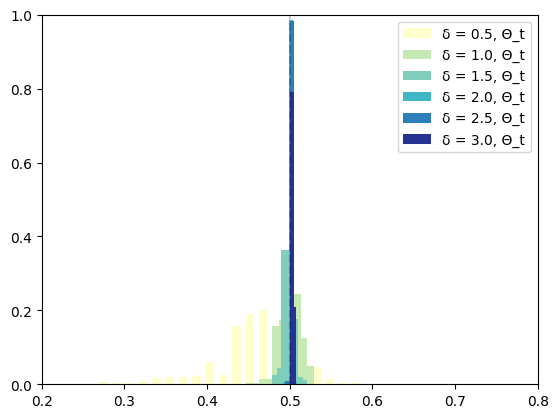

In [3]:
PAL3 = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
# PAL3 = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']
n_s = [int(δ * p) for δ in δ_list]
C_indx = np.arange(C_s.shape[0])
indices = lambda n: np.arange(int(3*n/8), int(5*n/8), 1)
idx = lambda n: np.linspace(0, 1, int(5*n/8)-int(3*n/8))
# post_list
prior = [1/C_s.shape[0] for i in range(C_s.shape[0])]
# plt.bar(C_indx, prior, alpha=0.5, label="prior")
plt.bar(idx(n_s[0]), post_list[0].flatten(), width = 0.01, alpha=1, label="δ = 0.5, Θ_t", color=PAL3[0])
plt.bar(idx(n_s[1]), post_list[1].flatten(), width = 0.01, alpha=1, label="δ = 1.0, Θ_t", color=PAL3[1])
plt.bar(idx(n_s[2]).flatten(), post_list[2].flatten(), width = 0.01, alpha=1, label="δ = 1.5, Θ_t", color=PAL3[2])
plt.bar(idx(n_s[3]).flatten(), post_list[3].flatten(), width = 0.005, alpha=1, label="δ = 2.0, Θ_t", color=PAL3[3])
plt.bar(idx(n_s[4]).flatten(), post_list[4].flatten(), width = 0.005, alpha=1, label="δ = 2.5, Θ_t", color=PAL3[4])
plt.bar(idx(n_s[5]).flatten(), post_list[5].flatten(), width = 0.005, alpha=1, label="δ = 3.0, Θ_t", color=PAL3[5])
# draw a vertical line at the true change point
plt.axvline(x=0.5, color='k', linestyle='--', alpha = 0.2)
# plt.bar(C_indx, post_list[1], alpha=0.5, label="δ = 1.0")
plt.ylim(0, 1)
plt.xlim(0.2, 0.8)
plt.legend()
plt.show()
# plt.plot(post_list)

### Try out different ways of visualizing

/var/folders/kh/5q2qjwdd4sz5cvjt10c51cgh0000gn/T/ipykernel_85413/2338435332.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


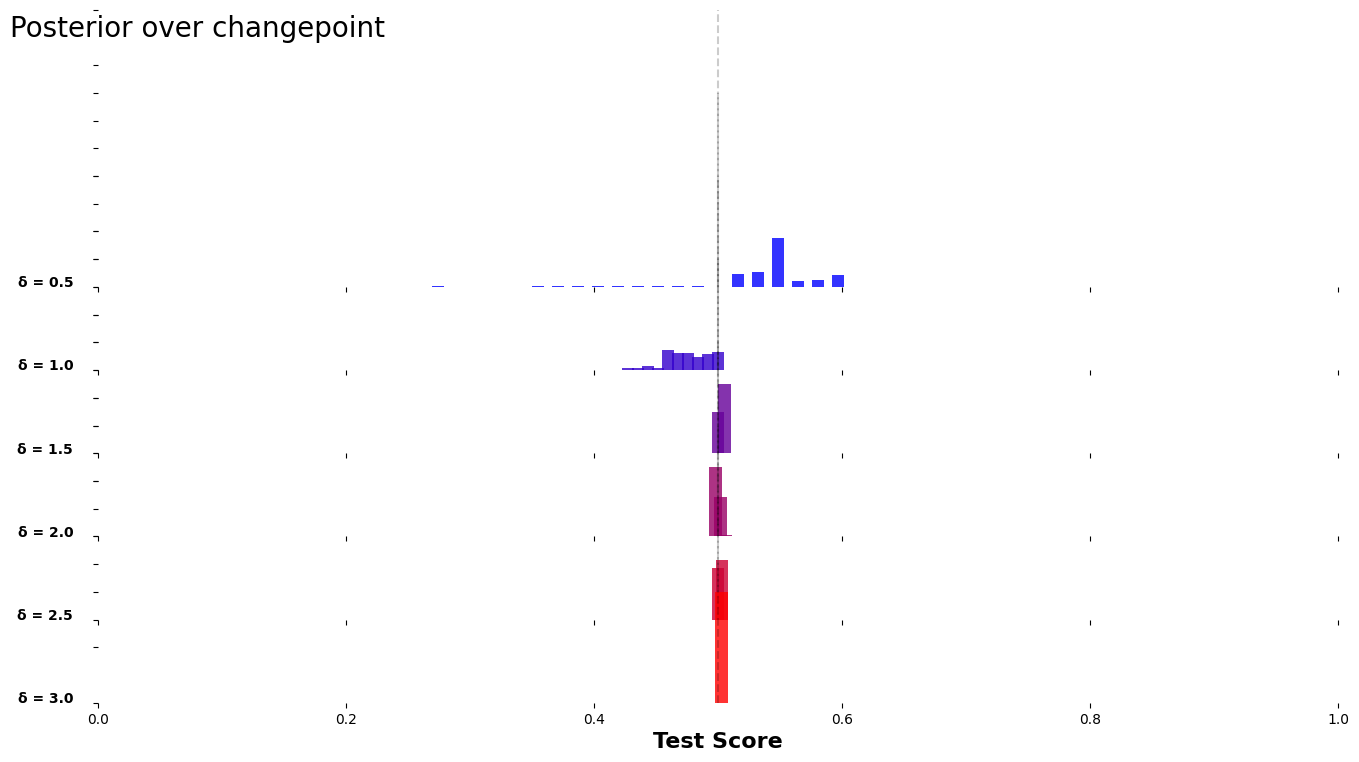

In [50]:
### Ridgeplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
# from sklearn.neighbors import KernelDensity

# countries = [x for x in np.unique(data.country)]
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(post_list),1)
fig = plt.figure(figsize=(16,9))

n_s = [int(δ * p) for δ in δ_list]
C_indx = np.arange(C_s.shape[0])
indices = lambda n: np.arange(int(3*n/8), int(5*n/8), 1)
idx = lambda n: np.linspace(0, 1, int(5*n/8)-int(3*n/8))
PAL3 = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']

i = 0

ax_objs = []
for j in range(len(post_list)):
    # country = countries[i]
    # x = 
    x_d = idx(n_s[j])

    # kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    # kde.fit(x[:, None])

    # logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    # ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    # ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])
    ax_objs[-1].bar(x_d, post_list[j].flatten(), width = 0.01, alpha=0.8, label="δ = 1.0, Θ_t", color=colors[j])
    ax_objs[-1].axvline(x=0.5, color='k', linestyle='--', alpha = 0.2)

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,1)
    ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(post_list)-1:
        ax_objs[-1].set_xlabel("Test Score", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    # adj_country = country.replace(" ","\n")
    adj_country = "δ = " + str(δ_list[j])
    ax_objs[-1].text(-0.02,0,adj_country,fontweight="bold",fontsize=10,ha="right")


    i += 1

gs.update(hspace=-0.7)

fig.text(0.07,0.85,"Posterior over changepoint",fontsize=20)

plt.tight_layout()
plt.show()

/var/folders/kh/5q2qjwdd4sz5cvjt10c51cgh0000gn/T/ipykernel_9653/3413773890.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


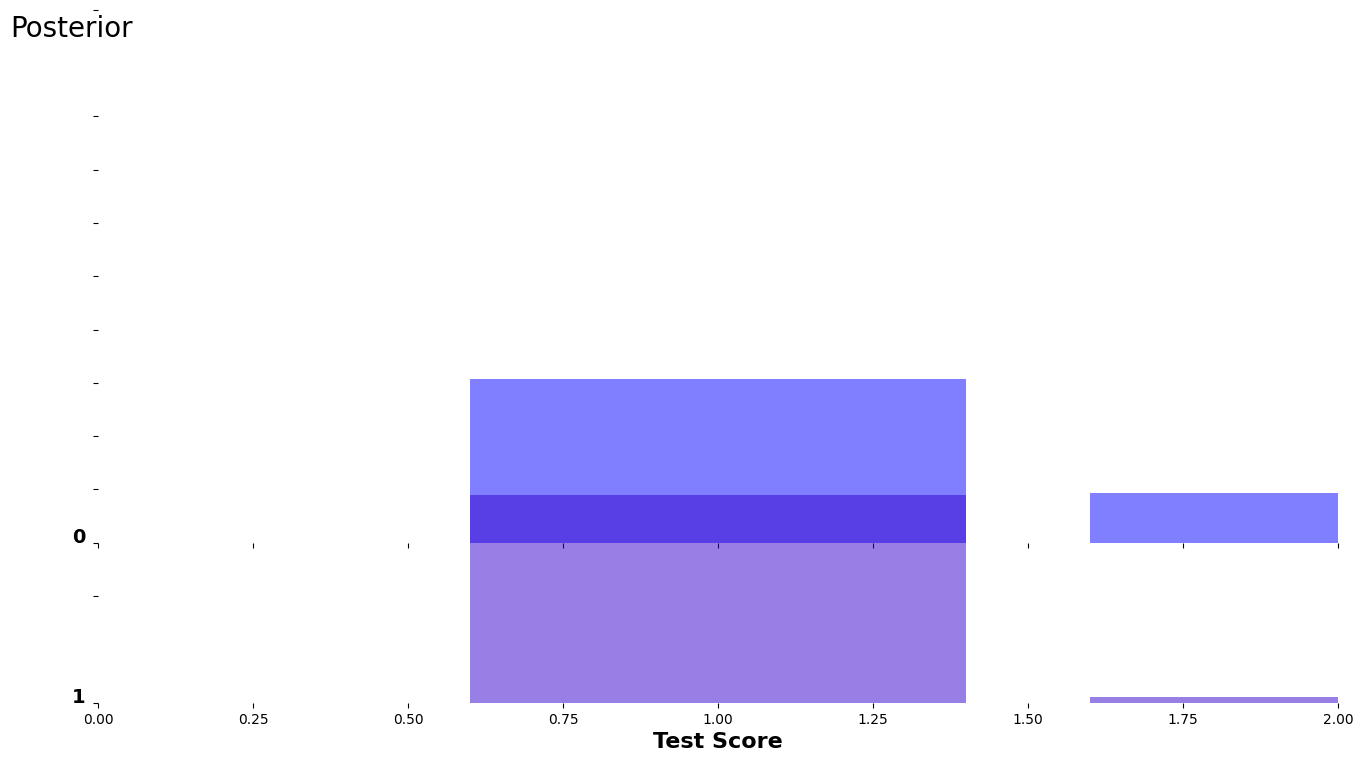

In [26]:
### Ridgeline plot
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

countries = [str(j) for j in range(0, len(δ_list))]
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(countries),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for country in countries:
    country = countries[i]
    x_d = C_indx

    prob = post_list[int(country)]

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].bar(x_d, prob,color=colors[i], alpha = 0.5)
    # ax_objs[-1].fill_between(x_d, prob, alpha=1,color=colors[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,C_indx[-1])
    ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == len(countries)-1:
        ax_objs[-1].set_xlabel("Test Score", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_country = country.replace(" ","\n")
    ax_objs[-1].text(-0.02,0,adj_country,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.7)

fig.text(0.07,0.85,"Posterior",fontsize=20)

plt.tight_layout()
plt.show()

# Check posterior coverage match with state evolution

### First, check that AMP and SE match on SqCorr

  0%|          | 0/7 [00:00<?, ?it/s]

--- δ:  0.5  ---
num_trials:  10


 14%|█▍        | 1/7 [00:22<02:14, 22.44s/it]

--- δ:  1.0  ---
num_trials:  10


 29%|██▊       | 2/7 [00:51<02:11, 26.36s/it]

--- δ:  1.5  ---
num_trials:  10


 43%|████▎     | 3/7 [01:26<02:01, 30.38s/it]

--- δ:  2.0  ---
num_trials:  10


 57%|█████▋    | 4/7 [02:04<01:40, 33.44s/it]

--- δ:  2.5  ---
num_trials:  10


 71%|███████▏  | 5/7 [02:45<01:11, 35.91s/it]

--- δ:  3.0  ---
num_trials:  10


 86%|████████▌ | 6/7 [03:28<00:38, 38.57s/it]

--- δ:  3.5  ---
num_trials:  10


100%|██████████| 7/7 [04:16<00:00, 36.62s/it]


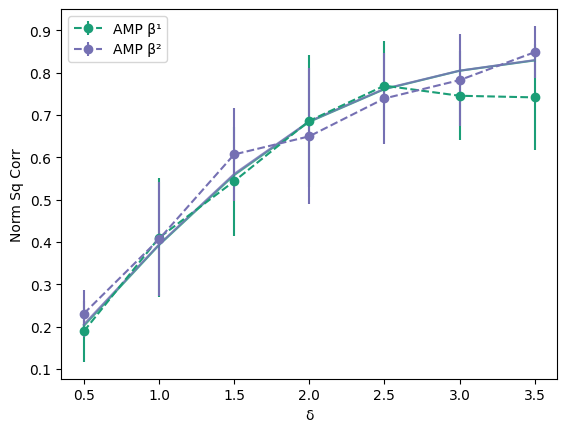

In [1]:
import jax
import jax.numpy as np
import numpy
import numpy.random as nprandom
import tqdm
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
import matplotlib.pyplot as plt
import random
from amp import MSE, norm_sq_corr, PAL
from amp.marginal_separable_jax import q, GAMP_gaussian_clean
import amp.changepoint_jax as chgpt_jax
# import amp.separable_jax
import amp.signal_configuration

p = 500
σ = 0.2 # noise standard deviation
# ϕ = jnp.array([0.2, 0.3, 0.5]) 
# Signal prior now as a vector (entries should sum to 1)
L = 2

T = 10 # num_iterations

norm_sq_corr_1_list = []
norm_sq_corr_2_list = []
norm_sq_corr_1_SE_list = []
norm_sq_corr_2_SE_list = []
std_norm_sq_corr_1_list = []
std_norm_sq_corr_2_list = []
std_norm_sq_corr_1_SE_list = []
std_norm_sq_corr_2_SE_list = []

δ_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
# δ_list = [0.5, 1.0, 1.5, 2.0]
for δ in tqdm(δ_list):
    print("--- δ: ", δ, " ---")

    trial_norm_sq_corr_1_list = []
    trial_norm_sq_corr_2_list = []
    trial_norm_sq_corr_1_SE_list = []
    trial_norm_sq_corr_2_SE_list = []

    n = int(δ * p)
    # num_trials = int(n / 20)
    num_trials = 10
    # num_trials = 20
    print("num_trials: ", num_trials)


    # def run_trial(trial_num):
    for trial_num in tqdm(range(num_trials)): 

        B̃_cov = np.eye(L)
        B̃ = nprandom.multivariate_normal(np.zeros(L), B̃_cov, size=p)
        B̂_0 = nprandom.multivariate_normal(np.zeros(L), B̃_cov, size=p)

        ϕ = np.zeros((L, n))
        # Changepoint highly concentrated
        ξ = int(n/2) # number of middle indices to concentrate the changepoint probability
        ξ_start = int((n - ξ)/2)
        ξ_end = int((n + ξ)/2)
        ϕ = ϕ.at[0, :ξ_start].set(np.ones(ξ_start))
        ϕ = ϕ.at[1, :ξ_start].set(np.zeros(ξ_start))
        ϕ = ϕ.at[0, ξ_start:ξ_end].set(np.arange(int(ξ)-1, -1, -1) / int(ξ))
        # ϕ = ϕ.at[0, ξ_end].set((0 + ϵ) / n) # Numerically stabilize the zero entries in the marginals ϕ
        ϕ = ϕ.at[1, ξ_start:ξ_end].set(np.arange(1, int(ξ) + 1, 1) / int(ξ))
        # ϕ = ϕ.at[1, ξ_end].set((n - ϵ) / n) # Numerically stabilize the zero entries in the marginals ϕ
        ϕ = ϕ.at[0, ξ_end:].set(np.zeros(int(n - ξ_end)))
        ϕ = ϕ.at[1, ξ_end:].set(np.ones(int(n - ξ_end)))

        # Mixed Unbalanced ϕ
        # ϕ = ϕ.at[0, :].set(0.7 * np.ones(n)) # Marginal probability of a changepoint happening at each index i <= n
        # ϕ = ϕ.at[1, :].set(0.3 * np.ones(n))

        # All possible allowed changepoint locations
        C_full = np.triu(np.ones((n, n)), k=0).astype(int) # Here we are creating the matrix of all possible C's. This assumes that one changepoint happens forsure between 0≤t≤n-1. 
        chgpt_true_location = np.array([random.randint(int( (n - ξ) / 2), int( (n + ξ) / 2))])
        C_s = C_full[int( (n - ξ) / 2) : int( (n + ξ) / 2)]
        C_true = C_full[chgpt_true_location][0] # Ask the AMP to search over 3 possible changepoint locations

        ϕ_from_C = amp.signal_configuration.C_to_marginal(C_s)

        assert np.allclose(ϕ_from_C, ϕ) # Testing whether the ϕ is constructed correctly. 

        ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later
        Y = np.zeros((n, 1))
        X = nprandom.normal(0, np.sqrt(1/n), (n, p))

        # Generate the observation vector Y
        Θ = X @ B̃
        assert Θ.shape == (n, L)
        Y = chgpt_jax.q(Θ, C_true, σ).sample()
        # Y = amp.separable_jax.q(Θ, ϕ[:, 0].flatten(), σ).sample()

        B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, verbose=False, seed=None, tqdm_disable = True)

        # return numpy.array([norm_sq_corr(B̂[:, 0], B̃[:, 0]), norm_sq_corr(B̂[:, 1], B̃[:, 1]), (ν[0, 0] / ρ[0, 0]), (ν[1, 1] / ρ[1, 1])])

        trial_norm_sq_corr_1_list.append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        trial_norm_sq_corr_2_list.append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        trial_norm_sq_corr_1_SE_list.append(ν[0, 0] / ρ[0, 0])
        trial_norm_sq_corr_2_SE_list.append(ν[1, 1] / ρ[1, 1])

    # res = numpy.apply_along_axis(run_trial, 0, numpy.ones((num_trials, 1))) # Gives me nan, or divide by zero errors for some reason
    # print("res: ", res)

    norm_sq_corr_1_list.append(np.mean(np.array(trial_norm_sq_corr_1_list)))
    norm_sq_corr_2_list.append(np.mean(np.array(trial_norm_sq_corr_2_list)))
    norm_sq_corr_1_SE_list.append(np.mean(np.array(trial_norm_sq_corr_1_SE_list)))
    norm_sq_corr_2_SE_list.append(np.mean(np.array(trial_norm_sq_corr_2_SE_list)))

    std_norm_sq_corr_1_list.append(np.std(np.array(trial_norm_sq_corr_1_list)))
    std_norm_sq_corr_2_list.append(np.std(np.array(trial_norm_sq_corr_2_list)))
    std_norm_sq_corr_1_SE_list.append(np.std(np.array(trial_norm_sq_corr_1_SE_list)))
    std_norm_sq_corr_2_SE_list.append(np.std(np.array(trial_norm_sq_corr_2_SE_list)))

# Sqcorr plots
plt.errorbar(δ_list, norm_sq_corr_1_list, yerr = std_norm_sq_corr_1_list, label="AMP β¹", marker="o", ls="--", c=PAL[0])
plt.errorbar(δ_list, norm_sq_corr_2_list, yerr = std_norm_sq_corr_2_list,  label="AMP β²", marker="o", ls="--", c=PAL[2])
plt.plot(δ_list, norm_sq_corr_1_SE_list, ls="-", alpha = 0.8, c=PAL[0])
plt.plot(δ_list, norm_sq_corr_2_SE_list, ls="-", alpha = 0.8, c=PAL[2])
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.legend()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

--- δ:  0.5  ---


  0%|          | 0/15 [00:00<?, ?it/s]

Calculating posterior...


  7%|▋         | 1/15 [00:05<01:22,  5.87s/it]

Calculating posterior...


 13%|█▎        | 2/15 [00:08<00:52,  4.03s/it]

Calculating posterior...


 20%|██        | 3/15 [00:11<00:40,  3.37s/it]

Calculating posterior...


 27%|██▋       | 4/15 [00:13<00:34,  3.14s/it]

Calculating posterior...


 33%|███▎      | 5/15 [00:16<00:30,  3.06s/it]

Calculating posterior...


 40%|████      | 6/15 [00:19<00:26,  2.90s/it]

Calculating posterior...


 47%|████▋     | 7/15 [00:22<00:22,  2.80s/it]

Calculating posterior...


 53%|█████▎    | 8/15 [00:24<00:19,  2.72s/it]

Calculating posterior...


 60%|██████    | 9/15 [00:27<00:16,  2.77s/it]

Calculating posterior...


 67%|██████▋   | 10/15 [00:30<00:14,  2.82s/it]

Calculating posterior...


 73%|███████▎  | 11/15 [00:33<00:11,  2.77s/it]

Calculating posterior...


 80%|████████  | 12/15 [00:35<00:08,  2.76s/it]

Calculating posterior...


 87%|████████▋ | 13/15 [00:38<00:05,  2.76s/it]

Calculating posterior...


 93%|█████████▎| 14/15 [00:41<00:02,  2.68s/it]

Calculating posterior...


 25%|██▌       | 1/4 [00:44<02:12, 44.04s/it]

--- δ:  1.0  ---


  0%|          | 0/15 [00:00<?, ?it/s]

Calculating posterior...


  7%|▋         | 1/15 [00:06<01:26,  6.20s/it]

Calculating posterior...


 13%|█▎        | 2/15 [00:09<00:57,  4.46s/it]

Calculating posterior...


 20%|██        | 3/15 [00:12<00:47,  3.94s/it]

Calculating posterior...


 27%|██▋       | 4/15 [00:16<00:40,  3.68s/it]

Calculating posterior...


 33%|███▎      | 5/15 [00:19<00:35,  3.60s/it]

Calculating posterior...


 40%|████      | 6/15 [00:22<00:31,  3.47s/it]

Calculating posterior...


 47%|████▋     | 7/15 [00:26<00:27,  3.45s/it]

Calculating posterior...


 53%|█████▎    | 8/15 [00:29<00:23,  3.43s/it]

Calculating posterior...


 60%|██████    | 9/15 [00:32<00:20,  3.41s/it]

Calculating posterior...


 67%|██████▋   | 10/15 [00:36<00:17,  3.46s/it]

Calculating posterior...


 73%|███████▎  | 11/15 [00:39<00:13,  3.40s/it]

Calculating posterior...


 80%|████████  | 12/15 [00:43<00:10,  3.41s/it]

Calculating posterior...


 87%|████████▋ | 13/15 [00:46<00:06,  3.37s/it]

Calculating posterior...


 93%|█████████▎| 14/15 [00:49<00:03,  3.36s/it]

Calculating posterior...


 50%|█████     | 2/4 [01:37<01:38, 49.48s/it]

--- δ:  1.5  ---


  0%|          | 0/15 [00:00<?, ?it/s]

Calculating posterior...


  7%|▋         | 1/15 [00:06<01:35,  6.79s/it]

Calculating posterior...


 13%|█▎        | 2/15 [00:11<01:10,  5.43s/it]

Credible Set Error 
Calculating posterior...


 20%|██        | 3/15 [00:15<01:00,  5.08s/it]

Calculating posterior...


 27%|██▋       | 4/15 [00:20<00:53,  4.84s/it]

Calculating posterior...


 33%|███▎      | 5/15 [00:24<00:46,  4.67s/it]

Calculating posterior...


 40%|████      | 6/15 [00:29<00:41,  4.57s/it]

Calculating posterior...


 47%|████▋     | 7/15 [00:33<00:36,  4.50s/it]

Calculating posterior...


 53%|█████▎    | 8/15 [00:37<00:31,  4.48s/it]

Calculating posterior...


 60%|██████    | 9/15 [00:42<00:27,  4.51s/it]

Calculating posterior...


 67%|██████▋   | 10/15 [00:46<00:22,  4.42s/it]

Calculating posterior...


 73%|███████▎  | 11/15 [00:50<00:17,  4.35s/it]

Calculating posterior...


 80%|████████  | 12/15 [00:55<00:12,  4.32s/it]

Calculating posterior...


 87%|████████▋ | 13/15 [00:59<00:08,  4.30s/it]

Calculating posterior...


 93%|█████████▎| 14/15 [01:03<00:04,  4.34s/it]

Calculating posterior...


 75%|███████▌  | 3/4 [02:45<00:58, 58.10s/it]

--- δ:  2.0  ---


  0%|          | 0/15 [00:00<?, ?it/s]

Calculating posterior...
Credible Set Error 


  7%|▋         | 1/15 [00:07<01:51,  7.96s/it]

Calculating posterior...


 13%|█▎        | 2/15 [00:13<01:24,  6.53s/it]

Calculating posterior...
Credible Set Error 


 20%|██        | 3/15 [00:18<01:12,  6.02s/it]

Calculating posterior...


 27%|██▋       | 4/15 [00:24<01:04,  5.82s/it]

Calculating posterior...
Credible Set Error 


 33%|███▎      | 5/15 [00:29<00:56,  5.70s/it]

Calculating posterior...


 40%|████      | 6/15 [00:35<00:50,  5.64s/it]

Calculating posterior...


 47%|████▋     | 7/15 [00:40<00:44,  5.54s/it]

Calculating posterior...


 53%|█████▎    | 8/15 [00:46<00:38,  5.48s/it]

Calculating posterior...


 60%|██████    | 9/15 [00:51<00:32,  5.46s/it]

Calculating posterior...
Credible Set Error 


 67%|██████▋   | 10/15 [00:56<00:27,  5.44s/it]

Calculating posterior...
Credible Set Error 


 73%|███████▎  | 11/15 [01:02<00:21,  5.44s/it]

Calculating posterior...


 80%|████████  | 12/15 [01:07<00:16,  5.42s/it]

Calculating posterior...


 87%|████████▋ | 13/15 [01:13<00:10,  5.40s/it]

Calculating posterior...


 93%|█████████▎| 14/15 [01:18<00:05,  5.40s/it]

Calculating posterior...


100%|██████████| 4/4 [04:09<00:00, 62.46s/it]


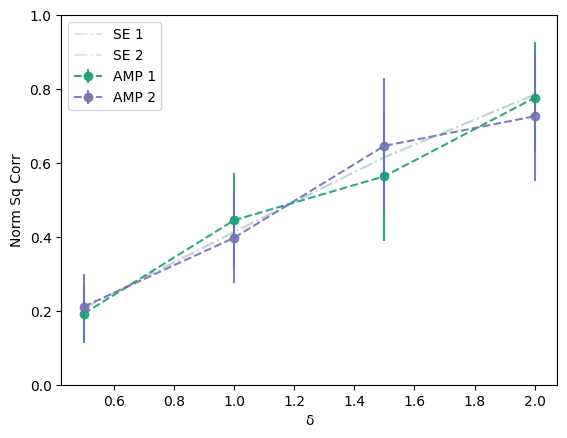

In [1]:
import numpy as np
import jax.numpy as jnp
import numpy.random as nprandom
import matplotlib.pyplot as plt
from amp import MSE, norm_sq_corr, PAL, hausdorff
from amp.marginal_separable_jax import q, GAMP_full, SE_fixed_C_v1, GAMP_gaussian_clean
import amp.marginal_separable_jax
import amp.changepoint_jax as changepoint_jax
import amp.signal_configuration
from amp.signal_priors import SignalPrior, SparseDiffSignal, SparseGaussianSignal, GaussianSignal
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

p = 750
σ = 0.1 # noise standard deviation
L = 2 # num signals. L-1 changepoints

T = 10 # num_iterations
num_trials = 15
# δ_list = [1.0, 1.5, 2.0, 2.5, 3.0]
δ_list = [0.5, 1.0, 1.5, 2.0]

# seed = 29
# nprandom.seed(2*seed)

norm_sq_corr_1_lists = [[] for i in range(len(δ_list))]
norm_sq_corr_2_lists = [[] for i in range(len(δ_list))]

norm_sq_corr_1_avg_list = []
norm_sq_corr_2_avg_list = []
norm_sq_corr_1_std_list = []
norm_sq_corr_2_std_list = []

norm_sq_corr_1_SE_list = []
norm_sq_corr_2_SE_list = []

norm_sq_corr_1_SE_fixed_lists = [[] for i in range(len(δ_list))]
norm_sq_corr_2_SE_fixed_lists = [[] for i in range(len(δ_list))]

norm_sq_corr_1_SE_fixed_avg_list = []
norm_sq_corr_2_SE_fixed_avg_list = []
norm_sq_corr_1_SE_fixed_std_list = []
norm_sq_corr_2_SE_fixed_std_list = []

mse_1_list = []
mse_2_list = []
mse_1_SE_list = []
mse_2_SE_list = []
post_list = [[] for i in range(len(δ_list))]
S_lower_upper_list = [[] for i in range(len(δ_list))]
coverage_list = [[] for i in range(len(δ_list))]
theory_post_list = [[] for i in range(len(δ_list))]
theory_S_lower_upper_list = [[] for i in range(len(δ_list))]
theory_coverage_list = [[] for i in range(len(δ_list))]
empirical_coverage_avg = []
empirical_coverage_std = []


for i in tqdm(range(len(δ_list))):
    δ = δ_list[i]
    print("--- δ: ", δ, " ---")

    n = int(δ * p)
    B̃_cov = np.eye(L)

    # Gaussian Prior
    signal_prior = GaussianSignal(B̃_cov)
    B̃ = signal_prior.sample(p)
    B̂_0 = signal_prior.sample(p)

    # Changepoint locations
    Δ = lambda n: int(n/4)
    C_s = amp.signal_configuration.generate_C_distanced(n, L, Δ = Δ(n))[1:-2] # Only consider cases with exactly one changepoint (not zero)
    # import matplotlib.pyplot as plt
    # plt.imshow(C_s, cmap='hot', interpolation='nearest') # Plot the possible signal configurations
    # # plt.axhline(y=C_true_idx, color='blue', linestyle='--', label="C_true")
    # plt.show()

    # true_chgpt_locations = lambda n: [int(n/3)]
    ϕ = amp.signal_configuration.C_to_marginal(C_s) 

    ρ = 1/δ * B̃_cov # 1/δ * Covariance matrix of each row of B_0, independent for now but should be generalized later

    for trial_num in tqdm(range(num_trials)):

        # Select a random true changepoint location
        # a, b = 1/4, 3/4
        # true_chgpt_locations = lambda n: [ int(((b - a) * np.random.random() + a)*n)]

        # C_true = np.zeros((n, )).astype(int)
        # loc = 0
        # for i in range(len(true_chgpt_locations(n)) + 1):
        #     if len(true_chgpt_locations(n)) == 0:
        #         break
        #     if i >= len(true_chgpt_locations(n)):
        #         C_true[loc:] = i
        #         break
        #     C_true[loc:true_chgpt_locations(n)[i]] = i
        #     loc = true_chgpt_locations(n)[i]
        j = np.random.randint(0, C_s.shape[0])
        C_true = C_s[j, :]
        # print("C_true_shape: ", C_true.shape)
        # print("C_true: ", C_true)

        # Generate the observation vector Y
        X = nprandom.normal(0, np.sqrt(1/n), (n, p))
        Θ = X @ B̃
        assert Θ.shape == (n, L)
        Y = changepoint_jax.q(Θ, C_true, σ).sample()
        assert Y.shape == (n, 1)

        # B̂, Θ_t, ν, ν̂ = GAMP(T, ϕ, σ, X, Y, signal_prior = signal_prior, verbose=False, seed=None)
        # κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
        # B̂, Θ_t, ν_arr, κ_T_arr, ν̂_arr, κ_B_arr = \
        #     GAMP_full(B̃, δ, p, ϕ, σ, X, Y, C_true, T = T, \
        #     true_signal_prior = signal_prior, \
        #         est_signal_prior = signal_prior, st_ζ = None, \
        #     verbose = False, seed = None, tqdm_disable = True)
        # ν_fixed, κ_T_fixed = SE_fixed_C_v1(\
        #     C_true, signal_prior, signal_prior, δ, p, ϕ, L, σ, T, \
        #         ν_arr, κ_T_arr, ν̂_arr, κ_B_arr, st_ζ = None, tqdm_disable = True)
        # ν, ν̂, κ_T, κ_B = ν_arr[-1], ν̂_arr[-1], κ_T_arr[-1], κ_B_arr[-1]
        # κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν
        # ν_fixed, κ_T_fixed = amp.marginal_separable_jax.SE_fixed_C(C_true, signal_prior, δ, p, ϕ, L, σ, 2 * T, tqdm_disable = True)

        B̂, Θ_t, ν, ν̂ = GAMP_gaussian_clean(B̂_0, δ, p, ϕ, L, σ, X, Y, ρ, T, prior = None, verbose=False, seed=None, tqdm_disable = True)
        κ_T = ν - ν.T @ np.linalg.inv(ρ) @ ν

        print("Calculating posterior...")
        ### --- Estimate Empirical coverage --- ###
        # Compute the approximate credible set S(Θ_t, Y)
        post_Θ_Y = amp.posterior.compute_posterior(C_s, Θ_t, Y, n, jnp.array(ρ), σ, ν, κ_T)
        post_list[i].append(post_Θ_Y)
        α_CI = 0.05
        try:
            S_lower, S_upper = amp.posterior.bayes_conf_interval(L, α_CI, C_s, post_Θ_Y)
        except:
            print("Credible Set Error ")
            S_lower, S_upper = None, None
        S_lower_upper_list[i].append((S_lower, S_upper))

        # Sample (V_Θ^t, Z), num_post_samp number of times . TODO: Continue from here, sample this num_post_samp number of times, because the plot below is heavily biased to be below nominal coverage. Also, double check that coverage is being calculated correctly. 
        num_post_samp = 100
        Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=(n, num_post_samp))))
        V_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
            jnp.zeros(L), κ_T, size=(n, num_post_samp))))
        Ȳ_samp = changepoint_jax.q(Z, C_true, σ).sample()
        post_V_Z = amp.posterior.compute_posterior(C_s, V_θ, Ȳ_samp, n, jnp.array(ρ), σ, ν, κ_T)
        if S_lower is not None:
            coverage_list[i].append(np.sum(post_V_Z[S_lower:S_upper]))
        # else:
        #     coverage_list[i].append(None)

        # ### --- True coverage according to theory --- ###
        # # Compute the approximate credible set S(V_θ, q(Z, Ψ))
        # # Sample (V_Θ^t, Z) 
        # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
        # V_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
        #     jnp.zeros(L), κ_T, size=n))).reshape(n, L)
        # Ȳ_samp = changepoint_jax.q(Z, C_true, σ).sample()
        # post_V_Z_1 = amp.posterior.compute_posterior(C_s, V_θ, Ȳ_samp, n, jnp.array(ρ), σ, ν, κ_T)
        # theory_post_list[i].append(post_V_Z_1)
        # α_CI = 0.05
        # try:
        #     S_lower, S_upper = amp.posterior.bayes_conf_interval(L, α_CI, C_s, post_V_Z_1)
        # except:
        #     S_lower, S_upper = None, None
        # theory_S_lower_upper_list[i].append((S_lower, S_upper))

        # # Sample (V_Θ^t, Z) 
        # Z = (np.array(nprandom.multivariate_normal(jnp.zeros(L), ρ, size=n))).reshape(n, L)
        # V_θ = (Z @ np.linalg.inv(ρ) @ ν + jnp.array(nprandom.multivariate_normal(
        #     jnp.zeros(L), κ_T, size=n))).reshape(n, L)
        # Ȳ_samp = changepoint_jax.q(Z, C_true, σ).sample()
        # post_V_Z_2 = amp.posterior.compute_posterior(C_s, V_θ, Ȳ_samp, n, jnp.array(ρ), σ, ν, κ_T)
        # theory_coverage_list[i].append(np.sum(post_V_Z_2[S_lower:S_upper]))

        norm_sq_corr_1_lists[i].append(norm_sq_corr(B̂[:, 0], B̃[:, 0]))
        norm_sq_corr_2_lists[i].append(norm_sq_corr(B̂[:, 1], B̃[:, 1]))
        # norm_sq_corr_1_SE_fixed_lists[i].append(ν_fixed[0, 0]**2 / ( ρ[0, 0] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[0, 0])) # Technically shouldn't need to do this since f is always optimal in our case right? 
        # norm_sq_corr_2_SE_fixed_lists[i].append(ν_fixed[1, 1]**2 / ( ρ[1, 1] * (κ_T_fixed + ν_fixed.T @ np.linalg.inv(ρ) @ ν_fixed)[1, 1]))

    norm_sq_corr_1_SE_list.append(ν[0, 0] / ρ[0, 0])
    norm_sq_corr_2_SE_list.append(ν[1, 1] / ρ[1, 1])
    # mse_1_list.append(MSE(B̂[:, 0], B̃[:, 0]))
    # mse_2_list.append(MSE(B̂[:, 1], B̃[:, 1]))
    # mse_1_SE_list.append(δ * (ρ[0, 0] - ν[0, 0]))
    # mse_2_SE_list.append(δ * (ρ[1, 1] - ν[1, 1]))

    norm_sq_corr_1_avg_list.append(np.mean(norm_sq_corr_1_lists[i]))
    norm_sq_corr_2_avg_list.append(np.mean(norm_sq_corr_2_lists[i]))
    norm_sq_corr_1_std_list.append(np.std(norm_sq_corr_1_lists[i]))
    norm_sq_corr_2_std_list.append(np.std(norm_sq_corr_2_lists[i]))

    # norm_sq_corr_1_SE_fixed_avg_list.append(np.mean(norm_sq_corr_1_SE_fixed_lists[i]))
    # norm_sq_corr_2_SE_fixed_avg_list.append(np.mean(norm_sq_corr_2_SE_fixed_lists[i]))
    # norm_sq_corr_1_SE_fixed_std_list.append(np.std(norm_sq_corr_1_SE_fixed_lists[i]))
    # norm_sq_corr_2_SE_fixed_std_list.append(np.std(norm_sq_corr_2_SE_fixed_lists[i]))

    empirical_coverage_avg.append(np.mean(coverage_list[i]))
    empirical_coverage_std.append(np.std(coverage_list[i]))

# Sqcorr plots with error bars
plt.errorbar(δ_list, norm_sq_corr_1_avg_list, yerr=norm_sq_corr_1_std_list, label="AMP 1", marker="o", ls="--", c=PAL[0], alpha = 0.9)
plt.errorbar(δ_list, norm_sq_corr_2_avg_list, yerr=norm_sq_corr_2_std_list, label="AMP 2", marker="o", ls="--", c=PAL[2], alpha = 0.9)
# plt.errorbar(δ_list, norm_sq_corr_1_SE_fixed_avg_list, yerr=norm_sq_corr_1_SE_fixed_std_list, label="SE-C 1", ls="-", c=PAL[0], alpha = 0.9)
# plt.errorbar(δ_list, norm_sq_corr_2_SE_fixed_avg_list, yerr=norm_sq_corr_2_SE_fixed_std_list, label="SE-C 2", ls="-", c=PAL[2], alpha = 0.9)
plt.plot(δ_list, norm_sq_corr_1_SE_list, label="SE 1", ls="-.", c=PAL[0], alpha = 0.2)
plt.plot(δ_list, norm_sq_corr_2_SE_list, label="SE 2", ls="-.", c=PAL[2], alpha = 0.2)
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.ylim(0, 1)
plt.legend()
plt.show()

# Plot the coverage level of the credible set
plt.errorbar(δ_list, empirical_coverage_avg, yerr=empirical_coverage_std, label="Empirical Coverage", marker="o", ls="-", c=PAL[0], alpha = 0.9)
# Plot a horizontal line at the true coverage level
plt.axhline(y=1 - α_CI, color='k', linestyle='--', alpha = 0.2, label="Nominal Coverage")
plt.xlabel("δ")
plt.ylabel("Coverage")
plt.ylim(0, 1)
plt.legend()
plt.show()



# # Sqcorr plots
# plt.plot(δ_list, norm_sq_corr_1_list, label="AMP 1", marker="o", ls="--", c=PAL[0])
# plt.plot(δ_list, norm_sq_corr_2_list, label="AMP 2", marker="o", ls="--", c=PAL[2])
# plt.plot(δ_list, norm_sq_corr_1_SE_list, label="SE 1", ls="-.", c=PAL[0], alpha = 0.2)
# plt.plot(δ_list, norm_sq_corr_2_SE_list, label="SE 2", ls="-.", c=PAL[2], alpha = 0.2)
# plt.plot(δ_list, norm_sq_corr_1_SE_fixed_list, label="SE-C 1", ls="-", c=PAL[0])
# plt.plot(δ_list, norm_sq_corr_2_SE_fixed_list, label="SE-C 2", ls="-", c=PAL[2])
# plt.xlabel("δ")
# plt.ylabel("Norm Sq Corr")
# plt.ylim(0, 1)
# plt.legend()
# plt.show()

# # MSE plots
# plt.plot(δ_list, mse_1_list, label="MSE Signal 1", marker="o", ls="--", c=PAL[0])
# plt.plot(δ_list, mse_2_list, label="MSE Signal 2", marker="o", ls="--", c=PAL[2])
# plt.plot(δ_list, mse_1_SE_list, label="MSE SE Signal 1", ls="-", c=PAL[0])
# plt.plot(δ_list, mse_2_SE_list, label="MSE SE Signal 2", ls="-", c=PAL[2])
# plt.xlabel("δ")
# plt.ylabel("MSE")
# plt.ylim(0, 1)
# plt.legend()
# plt.show()


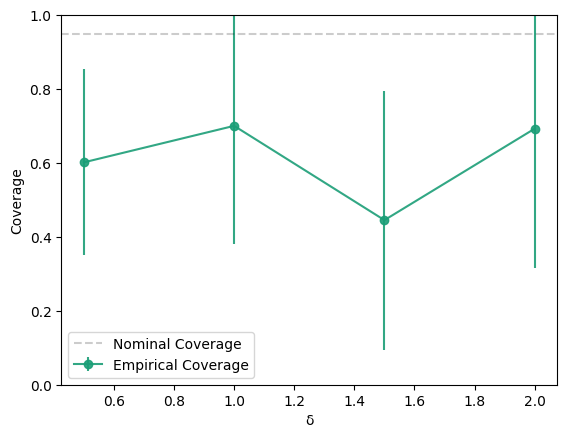

In [2]:
# Plot the coverage level of the credible set
plt.errorbar(δ_list, empirical_coverage_avg, yerr=empirical_coverage_std, label="Empirical Coverage", marker="o", ls="-", c=PAL[0], alpha = 0.9)
# Plot a horizontal line at the true coverage level
plt.axhline(y=1 - α_CI, color='k', linestyle='--', alpha = 0.2, label="Nominal Coverage")
plt.xlabel("δ")
plt.ylabel("Coverage")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [2]:
norm_sq_corr_1_SE_list

[DeviceArray(0.68902114, dtype=float64),
 DeviceArray(2.43752742, dtype=float64),
 DeviceArray(9.08284419, dtype=float64),
 DeviceArray(41.65359088, dtype=float64)]

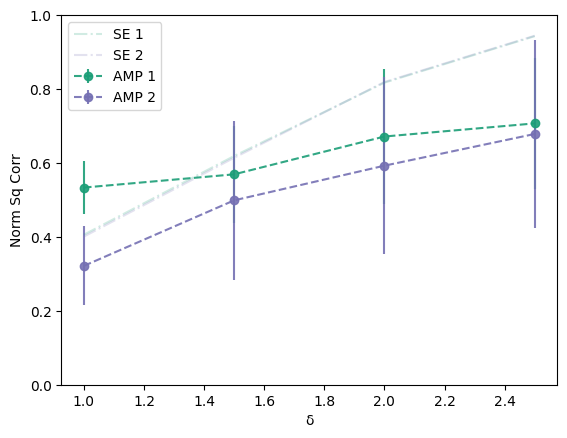

In [13]:
# Sqcorr plots with error bars
plt.errorbar(δ_list, norm_sq_corr_1_avg_list, yerr=norm_sq_corr_1_std_list, label="AMP 1", marker="o", ls="--", c=PAL[0], alpha = 0.9)
plt.errorbar(δ_list, norm_sq_corr_2_avg_list, yerr=norm_sq_corr_2_std_list, label="AMP 2", marker="o", ls="--", c=PAL[2], alpha = 0.9)
# plt.errorbar(δ_list, norm_sq_corr_1_SE_fixed_avg_list, yerr=norm_sq_corr_1_SE_fixed_std_list, label="SE-C 1", ls="-", c=PAL[0], alpha = 0.9)
# plt.errorbar(δ_list, norm_sq_corr_2_SE_fixed_avg_list, yerr=norm_sq_corr_2_SE_fixed_std_list, label="SE-C 2", ls="-", c=PAL[2], alpha = 0.9)
plt.plot(δ_list, norm_sq_corr_1_SE_list, label="SE 1", ls="-.", c=PAL[0], alpha = 0.2)
plt.plot(δ_list, norm_sq_corr_2_SE_list, label="SE 2", ls="-.", c=PAL[2], alpha = 0.2)
plt.xlabel("δ")
plt.ylabel("Norm Sq Corr")
plt.ylim(0, 1)
plt.legend()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

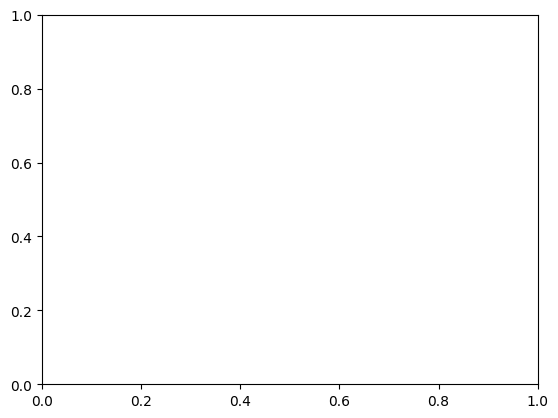

In [18]:
PAL3 = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
# PAL3 = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']
n_s = [int(δ * p) for δ in δ_list]
C_indx = np.arange(C_s.shape[0])
indices = lambda n: np.arange(int(3*n/8), int(5*n/8), 1)
idx = lambda n: np.linspace(0, 1, int(5*n/8)-int(3*n/8))
# post_list
prior = [1/C_s.shape[0] for i in range(C_s.shape[0])]
# plt.bar(C_indx, prior, alpha=0.5, label="prior")
# plt.bar(idx(n_s[0]), post_list[0], width = 0.01, alpha=1, label="δ = 0.5, Θ_t", color=PAL3[0])
plt.bar(idx(n_s[1]), post_list[1], width = 0.01, alpha=1, label="δ = 1.0, Θ_t", color=PAL3[1])
plt.bar(idx(n_s[2]).flatten(), post_list[2], width = 0.01, alpha=1, label="δ = 1.5, Θ_t", color=PAL3[2])
# plt.bar(idx(n_s[3]).flatten(), post_list[3].flatten(), width = 0.005, alpha=1, label="δ = 2.0, Θ_t", color=PAL3[3])
# plt.bar(idx(n_s[4]).flatten(), post_list[4].flatten(), width = 0.005, alpha=1, label="δ = 2.5, Θ_t", color=PAL3[4])
# plt.bar(idx(n_s[5]).flatten(), post_list[5].flatten(), width = 0.005, alpha=1, label="δ = 3.0, Θ_t", color=PAL3[5])
# draw a vertical line at the true change point
plt.axvline(x=0.5, color='k', linestyle='--', alpha = 0.2)
# plt.bar(C_indx, post_list[1], alpha=0.5, label="δ = 1.0")
plt.ylim(0, 1)
plt.xlim(0.2, 0.8)
plt.legend()
plt.show()
# plt.plot(post_list)

In [6]:
n_s

[250, 500, 750, 1000, 1250, 1500]

In [22]:
post_list[1][0].shape

(300,)

In [24]:
idx(n_s[1]).shape

(187,)